# 2D Glioma classification

This notebook demonstrates classification of brain tumors with MONAI. To accelerate training, 2D dataset is used based on the 3D one.

## Notebook structure

Here's a rough outline of this notebook:

1. Check MONAI is installed and install if not (plus any extra dependencies)
1. Import libraries
1. Set up the data (download or create)
1. Prepare for training -- create transforms, datasets, dataloaders
1. Do some quick visualisations
1. Create our model, loss function, etc.
1. Train 🎉🥳🎊
1. Check results

## Dataset

The dataset used here is the Decathlon 3D brain tumor dataset. We generate a 2D dataset by combining slices containing tumour, and those containing no tumourous voxels (considered healthy). We'll download the pre-computed dataset from Google Drive, but the script is available in case you're interested.

<p align="center">
  <img src="../figs/decathlon_brain_tumour_2d.png" alt="Example of Decathlon brain tumour image">
</p>

## User input

Some sections have been left blank for you, the user, to complete. Suggested solutions are hidden in a collapsible text box. Feel free to rely on these as much as necessary, but you will get the most of the experience if you think it through or search the internet prior to displaying the results. Remember there are lots of ways of achieving the same goal, so it's OK if your solutions are different!

## Extensions

1. We have a small amount of acceleration thanks to the `CacheDataset`, can you think of any other ways to make this training faster?
1. What methods could we use to reduce overfitting? Think about transforms and our model.
1. Could you use a different model or loss function altogether? Does this give better results?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rijobro/GliMR_MONAI_workshop/blob/main/01_classification/01_glioma_classification.ipynb)

## 1. Check MONAI is installed

This checks if MONAI is installed, and if not installs it (plus any optional extras that might be needed for this notebook).

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import gdown" || pip install -q gdown
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## 2. Import libraries

In [2]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tempfile
import torch
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

monai.config.print_config()

# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set deterministic training for reproducibility
set_determinism(seed=42)

MONAI version: 0.9.0+26.g112d36c6
Numpy version: 1.21.2
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 112d36c659b0cae510f44f78edfddea93ba314d3
MONAI __file__: /mnt/data/rbrown/Documents/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.4.0
transformers version: 4.14.1
mlflow version: 1.23.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## 3. Setup data

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

### 2D data

We'll download the pre-computed dataset from Google Drive, but the script is available in case you're interested.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/mnt/data/rbrown/Documents/Data/MONAI


In [4]:
download_from_gdrive = True
task = "Task01_BrainTumour"
output_dir = os.path.join(root_dir, task + "2D")

if download_from_gdrive:
    resource = "https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download"
    md5 = "214a338a26778c84ddebca29822add56"
    compressed_file = os.path.join(root_dir, task + "2D.tar")
    download_and_extract(resource, compressed_file, root_dir, hash_val=md5)
else:
    %run -i ../utils/2d_slice_creator.py --path {output_dir} --download_path {root_dir} --task {task}
    pass

# get all the 2d images
images_healthy = glob(os.path.join(output_dir, "image_healthy", "*.nii.gz"))
images_tumour = glob(os.path.join(output_dir, "image_tumour", "*.nii.gz"))
data_dicts = []
data_dicts += [{"image": i, "label": [1, 0]} for i in images_healthy]
data_dicts += [{"image": i, "label": [0, 1]} for i in images_tumour]

# shuffle the data and sort into training and validation
train_files, val_files = partition_dataset(data_dicts, ratios=(8, 2), shuffle=True)
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))

2022-07-05 14:57:37,011 - INFO - Verified 'Task01_BrainTumour2D.tar', md5: 214a338a26778c84ddebca29822add56.
2022-07-05 14:57:37,012 - INFO - File exists: /mnt/data/rbrown/Documents/Data/MONAI/Task01_BrainTumour2D.tar, skipped downloading.
2022-07-05 14:57:37,013 - INFO - Non-empty folder exists in /mnt/data/rbrown/Documents/Data/MONAI/Task01_BrainTumour2D, skipped extracting.
total num files: 968
num training files: 774
num validation files: 194


## 4. Prepare for training -- create transforms, datasets, dataloaders

### Transforms

In terms of transforms, we first load both the image and its corresponding label. We then rotate by 90 degrees, crop out superfluous zeros around the edge of the images, scale the image between 0 and 1 and then convert from numpy to pytorch.

In MONAI, we have two forms of transforms -- those that act on arrays of data, and those that act on dictionaries of data. For classification tasks, both are acceptable. We've used dictionaries here (note the `d` suffix in our transform names) –– such that each image and its corresponding class are stored together.

### Datasets and dataloaders

We use the `CacheDataset` which accelerates things by pre-computing the results of our deterministic transforms. We then use a batch size of 10 in our dataloader.

In [5]:
train_transforms = val_transforms = mt.Compose(
    [
        mt.LoadImaged("image"),
        mt.Rotate90d("image"),
        mt.CropForegroundd("image", source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(["image", "label"]),
    ]
)

In [6]:
# The cache dataset loads in our images and keeps them in the RAM to save time on each loop.
# We use the pad_list_data_collate so that all images in our batch of data are the same size.
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=10,
                          num_workers=10, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(
    data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=10,
                        num_workers=10, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 194/194 [00:00<00:00, 201.88it/s]


## 5. Display some examples

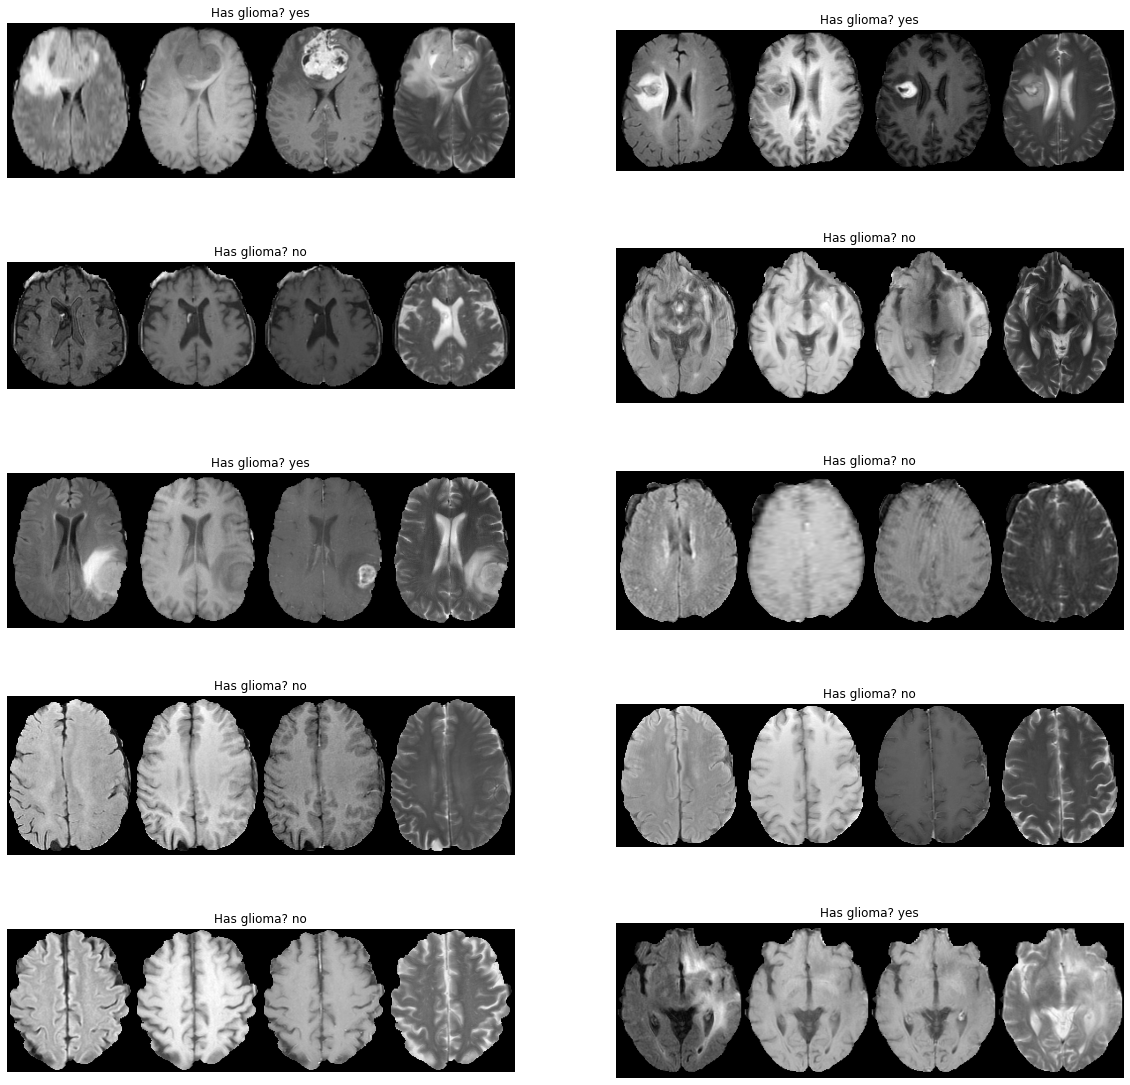

In [7]:
nrow, ncol = 5, 2
num_files = nrow * ncol
files_to_visualize = np.random.choice(train_files, size=num_files, replace=False)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20), facecolor='white')
for f, ax in zip(files_to_visualize, axes.flatten()):
    data = train_transforms(f)
    # different modalities side by side
    img = np.concatenate(list(data["image"]), axis=1)
    im_show = ax.imshow(img, cmap="gray")
    ax.set_title(f"Has glioma? {['yes', 'no'][data['label'][0]]}")
    ax.axis("off")

## 6. Create the model, loss function, etc.

### The model

Which network do you want to use? How many channels should go in and how many should come out?
<details>
  <summary>👉 Click to see an example model! 👈</summary>
  
  ```python
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)
  ```
</details>

### The loss function

Which loss function should you use? Remember that you're doing classification. How many channels are you dealing with? What kind of activation is needed?

<details>
  <summary>👉 Click to see an example loss function! 👈</summary>
  
  ```python
loss_function = torch.nn.CrossEntropyLoss()
  ```
</details>

In [8]:
# Insert your model here
model = None
model.to(device)

# Insert your loss function here
loss_function = None

In [9]:
# Helper function for inferring during validation
def infer_seg(images, model):
    return model(images).argmax(0)


# use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

# 7. Train!

In [10]:
# start a typical PyTorch training
best_model_path = "best_model_2d_glioma_classification.pth"
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses, metrics = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_path)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.0962, best val metric: 0.9433 at epoch 6: 100%|██████████| 10/10 [01:44<00:00, 10.50s/it]


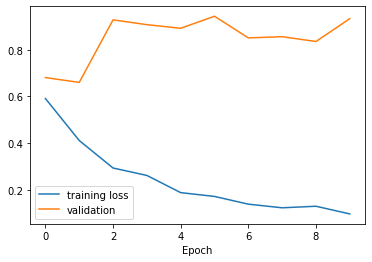

In [11]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses, label="training loss")
ax.plot(metrics, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()

In [12]:
model.load_state_dict(torch.load(best_model_path))
_ = model.eval()

# 8. Check classifications

Loop over validation files, and plot a confusion matrix so we get a feeling for how we're doing!

100%|██████████| 20/20 [00:01<00:00, 14.11it/s]


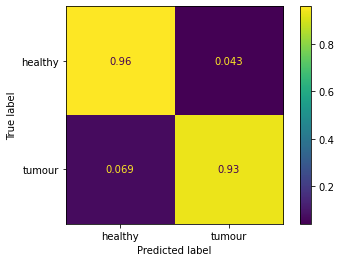

In [13]:
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])